In [1]:
import jax
import jax.numpy as jnp
from approx_post.distributions import approx, joint, amortised
from approx_post import losses, optimisers
import seaborn as sns
import matplotlib.pyplot as plt
from arraytainers import Jaxtainer
sns.set({'figure.facecolor':'white', "figure.figsize":(10,7)})

In [2]:
def create_data(model, theta_min, theta_max, num_batch, noise_cov, prngkey):
    theta_vals = jnp.linspace(theta_min, theta_max, num_batch) # shape = (num_batch, dim_x)
    mean_vals = model(theta_vals).reshape(num_batch, -1) # shape = (num_batch, dim_theta)
    # Zero-mean samples:
    x_dim = mean_vals.shape[1]
    epsilon = jax.random.multivariate_normal(prngkey, mean=jnp.zeros(x_dim), cov=noise_cov, shape=(num_batch,)) # shape = (num_batch, dim_x)
    # Add each mean on:
    samples = mean_vals + epsilon # shape = (num_batch, x_dim)
    return samples

In [3]:
# First, let's define a model:
ndim = 1
model = lambda theta: theta**2
model_grad = jax.vmap(jax.vmap(jax.jacfwd(model), in_axes=0), in_axes=0)

In [4]:
prngkey = jax.random.PRNGKey(20)
theta_min, theta_max = 0, 2
num_batch = 20
noise_cov = 0.1*jnp.identity(ndim)
data = create_data(model, theta_min, theta_max, num_batch, noise_cov, prngkey)

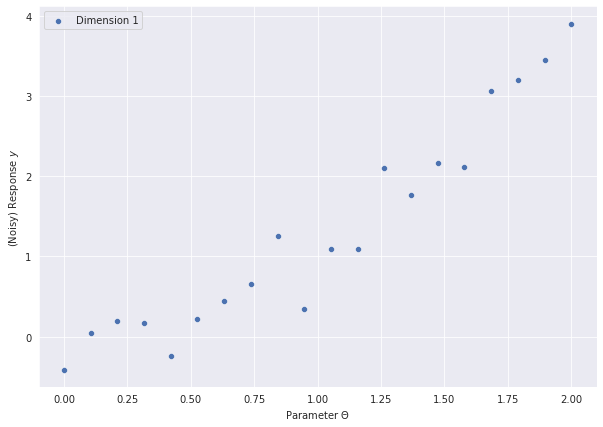

In [5]:
theta_vals = jnp.linspace(theta_min, theta_max, num_batch)
for i in range(ndim):
    sns.scatterplot(x=theta_vals, y=data[:,i], label=f"Dimension {i+1}")
plt.xlabel("Parameter $\Theta$")
plt.ylabel("(Noisy) Response $y$")
plt.show()

In [33]:
# Create Gaussian approximate distribution:
prngkey = jax.random.PRNGKey(21)
approx_dist = approx.Gaussian(ndim, var_bounds = (None, 1))
amortised_dist = amortised.NeuralNetwork(approx_dist, ndim, prngkey, num_layers=5, width=10, activation='relu')

In [7]:
# Create Joint distribution from forward model:
prior_mean = jnp.zeros(ndim)
prior_cov = jnp.identity(ndim)
joint_dist = joint.ModelPlusGaussian(model, noise_cov, prior_mean, prior_cov, model_grad)

In [10]:
# prngkey = jax.random.PRNGKey(20)
# loss = losses.ReverseKL(joint_dist, use_reparameterisation=True)
# optimiser = optimisers.Adam()
# optimiser.fit(amortised_dist, loss, data, prngkey, verbose=True)

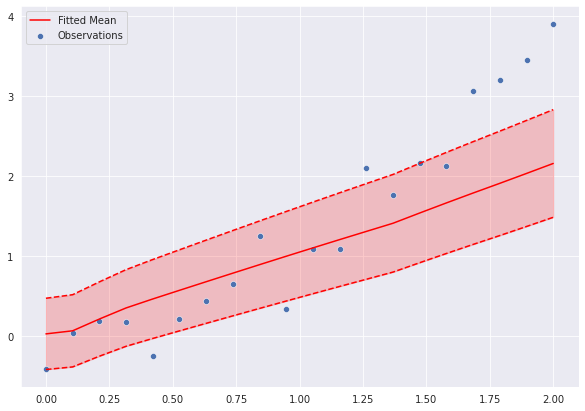

In [37]:
theta_vals = jnp.linspace(0, 2, num_batch)
pred_phi = amortised_dist.phi(theta_vals[:,None])
pred_mean, pred_cov = pred_phi['mean'].squeeze(), pred_phi['chol_diag'].squeeze()**2
mean_plus_cov = pred_mean+pred_cov
mean_minus_cov = pred_mean-pred_cov
ax = sns.lineplot(x=theta_vals, y=pred_mean, label=f"Fitted Mean", color='red')
sns.lineplot(x=theta_vals, y=mean_plus_cov, color='red', linestyle='--')
sns.lineplot(x=theta_vals, y=mean_minus_cov, color='red', linestyle='--')
ax.fill_between(theta_vals, mean_minus_cov, mean_plus_cov, color="red", alpha=0.2)
sns.scatterplot(x=theta_vals, y=data[:,0], label=f"Observations")
plt.show()

In [36]:
target = Jaxtainer({'mean': theta_vals[:,None]**2, 'chol_diag': jnp.ones((theta_vals[:,None].shape))})
mse_loss = losses.MSE(target)
optimiser = optimisers.GradDescent(lr=0.01)
optimiser.fit(amortised_dist, mse_loss, data, prngkey, verbose=True)

Loss = 105.8326187133789
Loss = 14.55465316772461
Loss = 54.64078140258789
Loss = 16.29961395263672
Loss = 43.25904846191406
Loss = 12.579267501831055
Loss = 18.39664649963379
Loss = 12.436834335327148
Loss = 11.278203964233398
Loss = 10.194292068481445
Loss = 9.746026992797852
Loss = 9.373480796813965
Loss = 9.141515731811523
Loss = 8.947033882141113
Loss = 8.80029582977295
Loss = 8.656366348266602
Loss = 8.552647590637207
Loss = 8.445857048034668
Loss = 8.329277038574219
Loss = 8.394089698791504
Loss = 8.921608924865723
Loss = 8.673917770385742
Loss = 8.510645866394043
Loss = 8.319941520690918
Loss = 8.21608829498291
Loss = 8.096266746520996
Loss = 8.022881507873535
Loss = 7.938599586486816
Loss = 7.872794151306152
Loss = 7.8082709312438965
Loss = 7.763606071472168
Loss = 7.720678329467773
Loss = 7.68569803237915
Loss = 7.637219429016113
Loss = 7.599272727966309
Loss = 7.511299133300781
Loss = 7.286194324493408
Loss = 7.21973991394043
Loss = 7.335753440856934
Loss = 7.2611083984375
L

KeyboardInterrupt: 